<a href="https://colab.research.google.com/github/SaurabhChakravorty/Watch-at-your-own-risk/blob/master/Saurabh_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

Inspired by the course assignment for [CSC321](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/) by Professor [Roger Grosse](http://www.cs.toronto.edu/~rgrosse/).

We will implement a Deep Convolutional GAN (DCGAN) introduced by [Radford et. al, 2015](https://arxiv.org/abs/1511.06434). A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator.

To implement the DCGAN, we need to specify three things: 
1. The generator
2. The discriminator, and 
3. The training procedure.

We will develop each of these three components in the following subsections.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Activation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model
import math
from tqdm import tqdm

# Discriminator

The discriminator in this DCGAN is a convolutional neural network that has the following architecture:

![Discriminator Architecture](https://imgur.com/download/A0hd29X/)

Padding: In each of the convolutional layers shown above, we downsample the spatial dimension of the input volume by a factor of 2. Given that we use kernel size K = 4 and stride S = 2, what should the padding be?

Complete the following function named `conv` that returns a Convolutional block according to the above schematic (Convolution followed by a BatchNorm followed by an Activation). The function takes an argument `x` which is the input tensor to the block, number of out-channels `c_out`. A `LeakyReLU` activation, with the slope of the leak set to `0.2` as mentioned in [Radford et. al., 2015](https://arxiv.org/abs/1511.06434), should be added to the block (we will use `LeakyReLU` even though the diagram mentions `ReLU`). There is a `weight_init` argument, which is 
an [initializer](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) object. It should be used to initialize the weights of the Convolutional layer in the block. 

The Convolutional layer should **not** have `bias` units.

Hint: Use the [Functional API](https://www.tensorflow.org/guide/keras/functional).

In [0]:
def conv(x, c_out, weight_init):

  x = Conv2D(c_out, 4 , 2, padding = 'same', use_bias = False, kernel_initializer=weight_init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  return x

Complete the following lines for the discriminator architecture `D` as shown in the schematic (shown again for reference). The `Input` layer expects an image of `32x32` with a single channel, followed by three convolutional blocks, and a final convolutional layer. The intermediate layer activations are `LeakyReLU`s. Use [He Uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_uniform) initializer for the convolutional layer in every block.

Use your implementation of the `conv` function from above for the three blocks.

Create a convolutional layer at the end (it should not have bias units and uses the [He Uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_uniform) intializer). Choose appropriate kernel size and stride so that the resulting dimensions of each element in the batch are `1x1x1`. Finally, flatten the output so that output shape is `(batch_size, 1)`. The diagram shows a cube of `1x1x1`, but we will have to flatten it sooner or later, so let's do it here. The final activation is `Sigmoid`.

![Discriminator Architecture](https://imgur.com/download/A0hd29X/)

In [0]:
# Complete the following code statements

input_image = Input(shape=(32,32,1))
d_block = conv(input_image,32,'he_uniform')
d_block = conv(d_block,64,'he_uniform')
d_block = conv(d_block,128,'he_uniform')
d_block = Conv2D(1,4,kernel_initializer='he_uniform',use_bias=False)(d_block)
d_block = Flatten()(d_block)
d_block = Activation('sigmoid')(d_block)

D = Model(input_image, d_block)

In [0]:
D.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        512       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0     

# Generator

Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose convolutional layers that progressively upsample the input noise sample to generate a fake image. The generator we’ll use in this DCGAN has the following architecture:

![Generator Architecture](https://imgur.com/download/jbmaWCV/)

If you need a refresher on tranpose convolutions, [this](https://arxiv.org/pdf/1603.07285.pdf) is a good resource.

Complete the following function named `deconv` that creates a block containing Conv2DTranspose followed by BatchNorm followed by Activation. The function takes the argument `x` which is the input tensor to the block, uses `Conv2DTranspose` layer (depicted as `deconv` layers in the schematic) to upscale the input. `Conv2DTranspose` upscales the input by a factor of 2. Use a kernel size size of 4 and pass appropriate stride value in the argument `stride`. The number of output channels is `c_out`. 

A `LeakyReLU` activation (with the slope of the leak set to `0.2`, in accordance with [Radford et. al., 2015](https://arxiv.org/abs/1511.06434)) should be added to the block (we will use `LeakyReLU` even though the diagram mentions `ReLU`). There is a `weight_init` argument, which is 
an [initializer](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) object. It should be used to initialize the weights of the `Conv2DTranspose` layer in the block. 

The `Conv2DTranspose` layer should **not** have `bias` units.

In [0]:
def deconv(x, stride, c_out, weight_init):
  # your code here 
  x = Conv2DTranspose(c_out, 4 ,strides=stride, padding = 'same',use_bias=False, kernel_initializer=weight_init)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  return x

Complete the following lines for the generator architecture `G` as shown in the schematic (shown again for reference). The `Input` layer expects a batch of vectors of size `1x1xz_dim`.  followed by three deconv blocks, and a final `Conv2DTranspose` layer. The intermediate layer activations are `LeakyReLU`s. Use [He Uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_uniform) initializer for the tranpose convolution layer in every block.

Use your implementation of the `deconv` function from above for the three blocks.

Create a `Conv2DTranspose` layer at the end (it should not have bias units and uses the [He Uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_uniform) intializer). Choose appropriate kernel size and stride so that the resulting dimensions of every element in the batch are `32x32x1`. The final activation is `Tanh`.

![Generator Architecture](https://imgur.com/download/jbmaWCV/)

In [0]:
z_dim = 100

# Complete the following code statements

input_noise = Input(shape=(1,1,z_dim))
g_block = deconv(input_noise, 4, 128,'he_uniform')
g_block = deconv(g_block,2,64,'he_uniform')
g_block = deconv(g_block,2,32,'he_uniform')
g_block = Conv2DTranspose(1,4,2,padding='same',use_bias=False,kernel_initializer='he_uniform')(g_block)
g_block = Activation('tanh')(g_block)

G = Model(input_noise, g_block)

In [0]:
G.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 64)          0   

# Helpers

Let's write some helper functions that would aid us in training GANs



This helper is going to help us plot images in a grid

In [0]:
# This function has been implemented for you. No modifications required

def plot_grid(images, rows, cols, figsize=(10, 10)):
    sample_ids = np.random.randint(0, images.shape[0], size=rows*cols)
    sample = images[sample_ids]
    sample = sample.squeeze(axis=-1)
    f, ax_arr = plt.subplots(rows, cols, figsize=figsize)
    plt.set_cmap(plt.cm.Greys_r)
    index = 0
    for i in range(rows):
        for j in range(cols):
            ax_arr[i, j].imshow(sample[index])
            ax_arr[i, j].axis('off')
            index +=1
    plt.show()
    plt.close()

The following helper function returns a batch of real images 



In [0]:
# This function has been implemented for you. No modifications required

def get_real_batch(data, batch_id, shuffle, batch_size):
    start_idx = int(batch_id * batch_size)
    end_idx = int((batch_id + 1) * batch_size)
    indices = shuffle[start_idx:end_idx]
    num_samples = indices.shape[0]
    return data[indices]

Write a function to fetch a batch of fake images of size `num_images`. Sample noise from a uniform distribution in the range `[-1, 1]`. `generator` is the GAN generator, z_dim is the dimension of noise vector that the generator expects. 

In [0]:
def sample_noise(num_images, z_dim):
    z = 2.0 * np.random.rand(batch_size,1,1,z_dim) - 1.0
    return z

In [0]:
def get_fake_batch(generator, z_dim, num_images):
    ## your code goes here
    z = sample_noise(num_images, z_dim)
    fakes = generator.predict(z)
    return fakes

# Load the MNIST training dataset
Load the MNIST dataset using TensorFlow's `tensorflow.keras.datasets.mnist` module. You will get both training and test sets. We will discard the test set, and go ahead with the training set.  

You will need to do the following changes in order to get things to work:

1. The images are of size `28x28`. However, out discriminator expects spatial dimensions of the image to be `32x32`. In order to make sizes match do a zero-padding using [numpy.pad](https://numpy.org/doc/1.18/reference/generated/numpy.pad.html) such that the images become `32x32`.  
2. The images are of shape `32x32`, but the discriminator expects images of dimensions `32x32x1`. Add the channel dimension to the images. 
3. Finally, normalize the images from `[0, 255]` to `[-1, 1]` as our generator network has a Tanh output activation layer.

Stored the normalized images in a variable `x_train`

In [0]:
## Load MNIST data here 
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.pad(x_train,[(0,0), (2,2), (2,2)],mode='constant',constant_values=0)
# Add a channel dimension
x_train = x_train[..., np.newaxis]
x_train = x_train.astype(np.float32) / 255.0
x_train = 2 * (x_train - 0.5)
print("Max Value : ",x_train.max())
print("Min Value : ",x_train.min())
print("Loaded dataset tensor size :", x_train.shape)
data_size = x_train.shape[0]
dim_size = x_train.shape[1] * x_train.shape[2]

Max Value :  1.0
Min Value :  -1.0
Loaded dataset tensor size : (60000, 32, 32, 1)


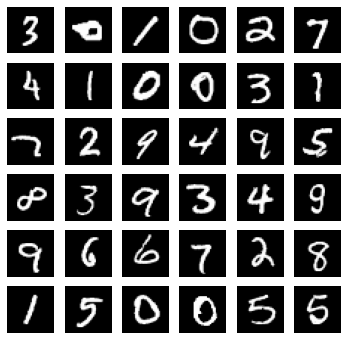

In [0]:
# Plot loaded data to see if everything is fine 
plot_grid(x_train, 6, 6, figsize=(6, 6))

# Hyperparamters

Let's set the hyperparameters for training. We will use `Adam` optimizer with a learning rate of ` 0.0002` and `beta_1=0.5`, as mentioned in [Radford et. al., 2015](https://arxiv.org/abs/1511.06434). Pick an appropriate loss function for calculating the minmax loss.

In [0]:
batch_size = 32
batch_size_half = 16
epochs = 10  # feel free to play with the number of epochs

# Total number of batches that the training set can be divided into
n_batches = math.floor(data_size / batch_size_half)

optim_d = Adam(0.0002, beta_1=0.5)
optim_g = Adam(0.0002, beta_1=0.5)
criterion = BinaryCrossentropy()

100%|██████████| 3750/3750 [03:19<00:00, 18.83it/s]


Epoch 1  out of 10  done !!!


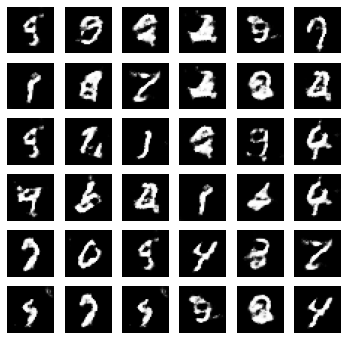

 38%|███▊      | 1409/3750 [01:14<02:00, 19.49it/s]

KeyboardInterrupt: ignored

In [0]:
shuffle = np.arange(data_size)

for ep in range(epochs):
    np.random.shuffle(shuffle)
    
    for batch_id in tqdm(range(n_batches)):
        # Train the discriminator
        x_real = get_real_batch(x_train, batch_id, shuffle, batch_size_half)
        y_real = np.ones((x_real.shape[0], 1))

        x_fake = get_fake_batch(G, z_dim, x_real.shape[0])
        y_fake = np.zeros((x_fake.shape[0], 1))

        X, Y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        with tf.GradientTape() as tape:
            predictions = D(X)
            d_loss = criterion(Y, predictions)
        grads = tape.gradient(d_loss, D.trainable_weights)
        optim_d.apply_gradients(zip(grads,D.trainable_weights))

        # Train the generator 
        z = sample_noise(batch_size, z_dim)
        labels = np.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = D(G(z))
            g_loss = criterion(labels, predictions)
        grads = tape.gradient(g_loss, G.trainable_weights)
        optim_g.apply_gradients(zip(grads,G.trainable_weights))

    # Plot generated images after every epoch
    print('Epoch', ep + 1, ' out of', epochs, ' done !!!')
    noise = sample_noise(36, z_dim)
    rand_imgs = G.predict(noise)
    plot_grid(rand_imgs, 6, 6, figsize=(6, 6))